The generated images below may slightly differ from those in the paper, but this does not impact our main conclusions. The discrepancy is primarily due to differences in the sorting of items with the same count by the value_counts function.

In [ ]:
import os
import sys
from pathlib import Path

# Set root and data directories
ROOT_DIR = Path(os.getcwd()).resolve().parent.parent
sys.path.insert(0,str(ROOT_DIR))
from path import DATA_DIR

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)

# Set plot directory
os.chdir(DATA_DIR / f"result_2025/down_stream_analysis")


ROOT_DIR: /root/project/reproducity
DATA_DIR: /data/sequential_data


In [2]:
import pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use("Agg")

mpl.rcParams.update({
    "axes.labelsize": 7,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.frameon": False,
    "legend.fontsize": 3,
    "axes.linewidth": 0.5,
    "pdf.fonttype": 42,
    "figure.dpi": 300,
})
%matplotlib inline


## 1. Read and processes MoA data
MoA data for multiple cell lines and computes statistics for the top 10 most frequent pathways in each class. 

In [3]:
# List of cell lines to process
all_ccls = ["A375", "MDAMB231", "SKBR3", "MCF7", "HS578T", "BT20", "HEPG2", "HUH7", "HCC515", "A549"]
all_res = []

# Process each cell line
for cell_line in all_ccls:
    # Load MoA data from pickle file
    with open(f"MoA_res/{cell_line}.pkl", "rb") as f:
        MoA_dict = pickle.load(f)

    # Collect class labels (for each MoA, store its corresponding class index)
    class_arr = [
        i for i in range(1, 8) for _ in range(MoA_dict[(cell_line, i)].shape[0]) if MoA_dict[(cell_line, i)].shape[0] != 0
    ]

    # Merge all MoA data for the current cell line into a DataFrame
    ccl_MoA_res = pd.concat(MoA_dict.values())
    ccl_MoA_res["cell line"] = cell_line  # Add cell line column
    ccl_MoA_res["class index"] = class_arr  # Add class index column
    all_res.append(ccl_MoA_res)

# Merge all cell line data into a single DataFrame
all_res = pd.concat(all_res, ignore_index=True)

# Get the number of unique MoA types
top_n = len(np.unique(all_res["MoA"]))

# Count occurrences of each MoA across different cell lines
temp = all_res.drop_duplicates(["MoA", "cell line"]).value_counts("MoA")
MoA_keys = list(temp.index)[0:top_n]
MoA_vals = temp.values[0:top_n]

# Recompute MoA frequency across all occurrences
MoA_keys = list(all_res.value_counts("MoA").index)
MoA_vals = all_res.value_counts("MoA").values
MoA_keys = np.array(MoA_keys)

# Create a ranking dictionary for MoA and cell lines
MoA_dict = {key: value for key, value in zip(MoA_keys, list(range(top_n, 0, -1)))}
ccl_dict = {key: value for key, value in zip(all_ccls, list(range(1, len(all_ccls) + 1)))}

# Load MoA name mapping file
MoA_dict_new = {}
MoA_change_df = pd.read_excel(ROOT_DIR.parent / "data/drug_type_name_modify.xlsx")

# Remove extra characters from original MoA names
MoA_change_df.iloc[:, 0] = [MoA_change_df.iloc[i, 0][2:] for i in range(MoA_change_df.shape[0])]
MoA_change_df.index = MoA_change_df.iloc[:, 0]  # Set index to modified MoA names

# Update MoA dictionary with new names
for k, v in MoA_dict.items():
    new_k = MoA_change_df.loc[k, "new name"].strip()  # Get the updated MoA name
    MoA_dict_new[new_k] = v  # Store new mapping
MoA_dict = MoA_dict_new  # Replace the old MoA dictionary

# Convert MoA dictionary keys to an array for easier processing
MoA_keys_list = list(MoA_dict.keys())
MoA_keys = np.array(MoA_keys_list)

# Reset index in MoA_change_df to prepare for merging
MoA_change_df = MoA_change_df.reset_index(drop=True)

# Merge MoA name mapping with the processed MoA data
all_res_newname = pd.merge(MoA_change_df, all_res, left_on='original name', right_on='MoA')

# Drop unnecessary columns after merging
all_res_newname.drop(columns=['original name', 'new name (Chinese)', 'MoA'], inplace=True)

# Rename 'new name' column as 'MoA' in the final DataFrame
all_res = all_res_newname.rename(columns={'new name': 'MoA'})
all_res['MoA'] = all_res['MoA'].str.strip()  # Ensure no extra spaces in MoA names


## 2. Create plot data

In [4]:
x_arr = []
y_arr = []
val_arr = []
p_arr = []
pair_arr = []
for i in range(all_res.shape[0]):
    if all_res.iloc[i, 0] in MoA_dict.keys():
        x_arr.append(ccl_dict[all_res.iloc[i, -2]])
        y_arr.append(MoA_dict[all_res.iloc[i, 0]])
        pair_arr.append((ccl_dict[all_res.iloc[i, -2]],MoA_dict[all_res.iloc[i, 0]]))
        val_arr.append(all_res.iloc[i, 3])
        p_arr.append(all_res.iloc[i, 4])
val_arr_norm = list(val_arr/np.max(val_arr))

# 3. Plot

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [2, 1.5, 1]})

# ======= 1. Scatter Plot (Bubble Heatmap) =======
scatter = axes[0].scatter(
    x_arr, y_arr, alpha=0.6, sizes=np.array(val_arr_norm) * 90, 
    edgecolors="#323232", linewidths=0.5, c=-np.array(p_arr), cmap="Blues", vmin=-0.05
)

# X-axis settings (Cell lines)
axes[0].set_xticks(np.arange(1, len(all_ccls) + 1))
axes[0].set_xticklabels(all_ccls, rotation=45, ha='right')  # Removed Arial font
axes[0].tick_params(axis='x', direction='out', length=1)

# Y-axis settings (Pathways)
axes[0].set_ylim([0.5, top_n + 0.8])
axes[0].set_yticks(np.arange(1, top_n + 1))
axes[0].yaxis.tick_right()
axes[0].set_yticklabels([" "] * top_n)
axes[0].tick_params(axis='y', direction='out', length=1)

# Plot title
axes[0].set_title("Drug types of drug A", fontsize=7)  # Removed Arial font

# Add grid lines
for i in range(1, len(all_ccls) + 1):
    axes[0].axvline(x=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)
for i in range(top_n + 1):
    axes[0].axhline(y=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)

# ======= 2. Color and Size Legends =======
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_xaxis().set_visible(False)

# Y-axis settings for MoA names
axes[1].set_ylim([0.5, top_n + 0.8])
axes[1].set_yticks(np.arange(1, top_n + 1))
axes[1].set_yticklabels(MoA_keys[::-1], ha="left")  # Removed Arial font
axes[1].tick_params(axis='y', direction='out', length=0)

# Add colorbar
cax = fig.add_axes([1, 0.5, 0.02, 0.2]) 
cbar = plt.colorbar(scatter, ax=axes[0], cax=cax)
cbar.set_label('color_arr')  # Removed Arial font

# Add size legend
legend_sizes = [90, 45, 18, 1.8]
legend_labels = ['50', '25', '10', '1']
scatter_legend = [
    axes[1].scatter([], [], s=size, label=label, edgecolors="#323232", linewidths=0.5, color='black')
    for size, label in zip(legend_sizes, legend_labels)
]
axes[1].legend(handles=scatter_legend, title='', bbox_to_anchor=(2.35, 1.0), loc='best', labelspacing=2.0)

# ======= 3. Horizontal Bar Chart (Pathway Count) =======
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].barh(np.arange(1, top_n + 1), MoA_vals[::-1], align="center", color='#5D80AA')

# Y-axis settings
axes[2].set_ylim([0.5, top_n + 0.8])
axes[2].set_yticks(np.arange(1, top_n + 1))
axes[2].set_yticklabels([" "] * top_n)
axes[2].tick_params(axis='y', direction='out', length=1)

# X and Y axis settings for bar chart
axes[2].tick_params(axis='x', direction='out', length=1)
axes[2].set_title("Count", fontsize=7)  # Removed Arial font

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.1)


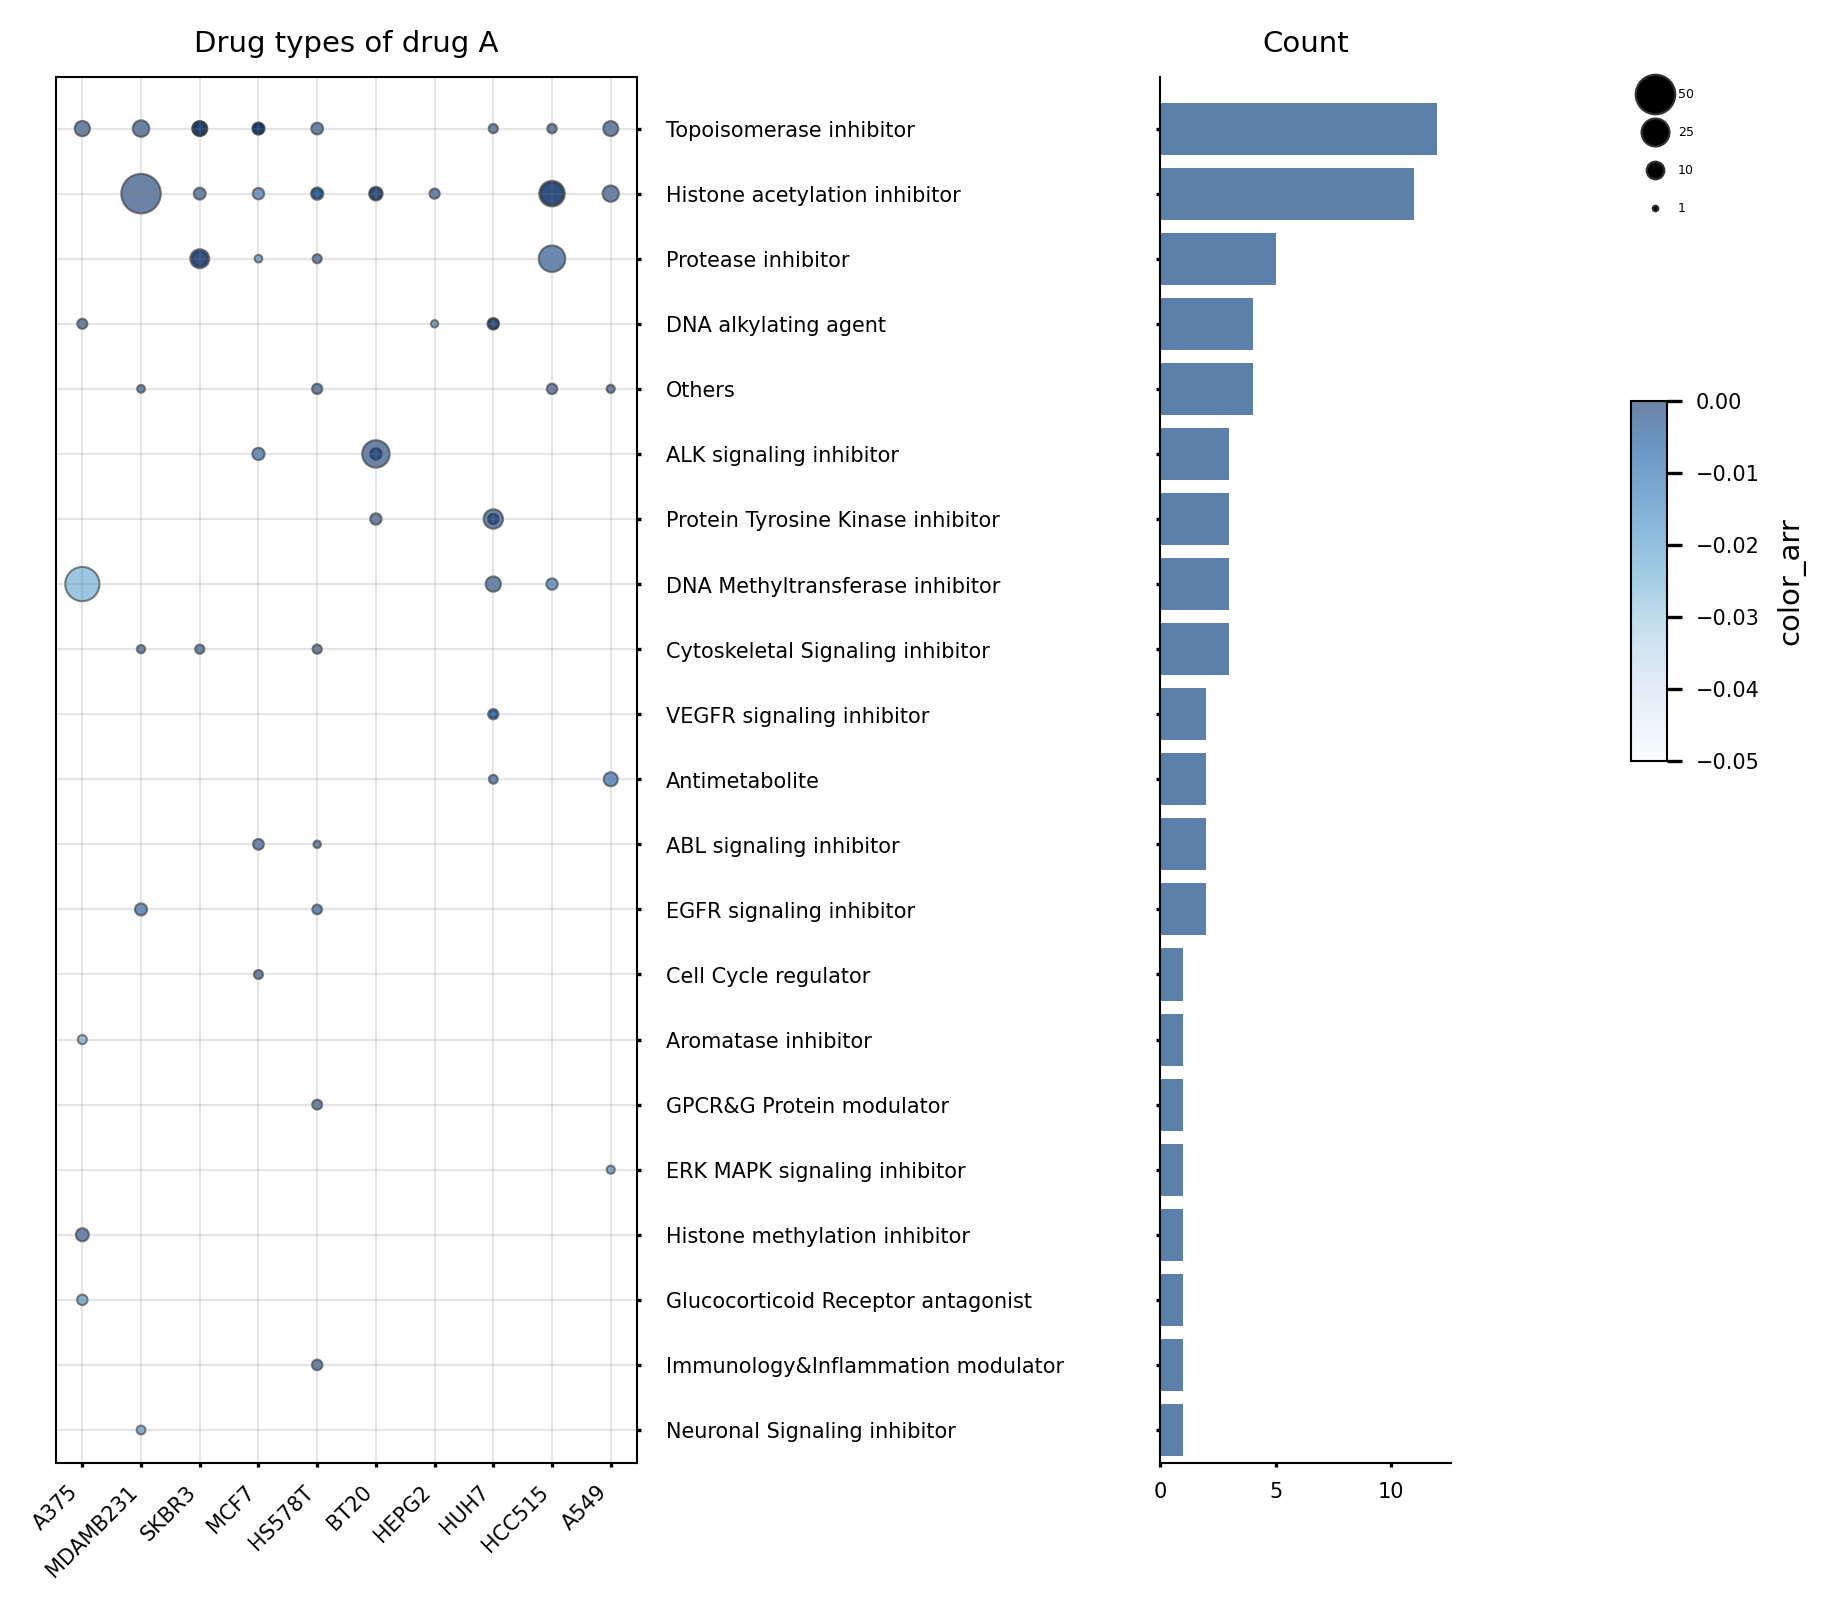

In [6]:
plt.show()